In [1]:
from GOlabels.scripts import labels
from GOlabels.scripts import hierarchyModule
from GOlabels.scripts import associationModule

## Playing with the GO labels scripts from r/BCB
They are very straight forward and easy to use. I just need to convert the MU
dataset into the correct format to be processed.

In [2]:
hm = hierarchyModule.hierarchyModule("GOlabels/data/ontology/go-basic.obo", 0)

In [3]:
am = associationModule.associationModule("GOlabels/data/associations/ensembl_peptide_id.associations")

In [4]:
testGene = am.labeledGenes[0]

In [5]:
testGene

'ENSP00000420919'

In [6]:
testLabel = list(am.labels(testGene))[0]

In [7]:
testLabel

'GO:0044459'

In [8]:
hm.translate('GO:0009987')

'GO:0009987'

In [9]:
hm.levelOf('GO:0009987')

1

## Re-formatting the MU dataset

In [1]:
fp_gene_list = "../data/networks/yeast/yeast_string_genes.txt"
file_gene_list = open(fp_gene_list, 'r')

# reads in the list of string genes
string_genes = []
for gene_line in file_gene_list.readlines():
    gene = gene_line.split()[0]
    string_genes.append(gene)
file_gene_list.close()

In [34]:
len(string_genes)

6400

In [2]:
# we need the map because the go and string indexing is not consistent.
idx = 1
string_map = {}
for gene in string_genes:
    string_map[gene] = idx
    idx += 1

In [35]:
len(string_map)

6400

In [3]:
fp_gogene_list = "../data/annotations/yeast/go_yeast_ref_genes.txt"
file_gogene_list = open(fp_gogene_list, 'r')

# reads the list of GO genes in
go_genes = []
for gene_line in file_gogene_list.readlines():
    gene = gene_line.split()[0]
    go_genes.append(gene)
file_gogene_list.close()

In [37]:
len(go_genes)

3571

In [38]:
filt = set()
for i in range(len(string_genes)):
    gene = string_genes[i]
    if gene in go_genes:
        filt.add(gene)

In [5]:
# reads in the list of GO terms being used
fp_go_term_list = "../data/annotations/yeast/go_yeast_ref_mf_terms.txt"
file_go_term_list = open(fp_go_term_list, 'r')

# reads in the list of GO terms
go_terms = []
for term_line in file_go_term_list.readlines():
    term = term_line.split()[0]
    go_terms.append(term)
file_go_term_list.close()

In [6]:
# creates dict with the gene indices as keys and the list of their go term indices as values
fp_go_adj = "../data/annotations/yeast/go_yeast_ref_mf_adjacency.txt"
file_go_adj = open(fp_go_adj, 'r')

gene_anno = {}
for i in range(len(go_genes)):
    gene_anno[i+1] = {'orig': []}

for map_line in file_go_adj.readlines():
    [gene_index, term_index] = map_line.split()
    gene_index = int(gene_index)
    term_index = int(term_index)

    # uses the gene indices
    gene_anno[gene_index]['orig'] += [term_index]

file_go_adj.close()

In [7]:
# map from index back to original gene name
gene_map = {}
for i in range(len(go_genes)):
    gene = go_genes[i]
    gene_map[gene] = i + 1

In [8]:
# reads in the mapping from go terms to their indices
fp_go_term_map = "../data/annotations/yeast/graph/go_mf.map"
file_go_term_map = open(fp_go_term_map, 'r')

go_term_map = [None]
go_term_reverse = {}
for map_line in file_go_term_map.readlines():
    [term, index] = map_line.split()
    index = int(index)
    
    go_term_reverse[term] = index
    
    # the index is sequential and this means we've seen it before
    if len(go_term_map) == index + 1:
        go_term_map[index] += [term]
    # this means its the first occurrence
    else:
        go_term_map += [[term]]
        

file_go_term_map.close()

In [9]:
# creates a DAG of the GO terms
fp_go_links = "../data/annotations/yeast/graph/go_mf.links"
file_go_links = open(fp_go_links, 'r')

index_tree = {}
for link_line in file_go_links.readlines():
    [parent_index, child_index] = link_line.split()
    parent_index = int(parent_index)
    child_index = int(child_index)

    if not parent_index in index_tree:
        index_tree[parent_index] = {'parents':[], 'children':[]}
    if not child_index in index_tree:
        index_tree[child_index] = {'parents':[], 'children':[]}
    index_tree[parent_index]['children'].append(child_index)
    index_tree[child_index]['parents'].append(parent_index)

file_go_links.close()

In [10]:
# find all the terms which have no parents and are therefore the root terms
roots = []
for index in index_tree:
    if len(index_tree[index]['parents']) == 0:
        roots.append(index)

In [11]:
# computing term depths

#preparing all nodes with auxillary fields
for index in index_tree:
    index_node = index_tree[index]
    index_node['visited'] = False
    index_node['level'] = 0 # indicates unknown

#preparing root nodes
queue = roots + []
for index in queue:
    index_node = index_tree[index]
    index_node['level'] = 1
    index_node['visited'] = True

while len(queue) > 0:
    parent_index = queue.pop(0)
    parent_node = index_tree[parent_index]
    
    child_indices = parent_node['children']
    for child_index in child_indices:
        child_node = index_tree[child_index]
        if child_node['visited']:
            continue
        else:
            child_node['visited'] = True
            child_node['level'] = parent_node['level'] + 1
            queue.append(child_index)

In [12]:
max_level = 0
for index in index_tree:
    level = index_tree[index]['level']
    max_level = max(level, max_level)

In [13]:
# associates each term index with all its ancestors

#prepares each tree node
for index in index_tree:
    index_node = index_tree[index]
    index_node['ancestors'] = {index}

for i in range(max_level):
    # go level by level pushing down ancestors
    cur_level = i + 1
    
    for index in index_tree:
        index_node = index_tree[index]
        
        # only look at nodes on the right level
        if index_node['level'] != cur_level:
            continue
        
        parents = index_node['parents']
        # grabs all the parents' ancestors (list of sets)
        ancestors = list(map(lambda pidx: index_tree[pidx]['ancestors'], parents))
        # unions over all parent ancestors + self (* unpacks the list of sets)
        index_node['ancestors'] = index_node['ancestors'].union(*ancestors)

In [14]:
# associates each gene index with all its ancestors
for gene_index in gene_anno:
    gene_node = gene_anno[gene_index]
    gene_node['comp'] = set().union(*list(map(lambda idx: index_tree[idx]['ancestors'], gene_node['orig'])))

In [15]:
# associates each term index with all genes indices that have it

# prepares each term index
for index in index_tree:
    index_node = index_tree[index]
    index_node['gene_inds'] = []
    
# go over each gene and append it to the indices
for gene_index in gene_anno:
    term_indices = list(gene_anno[gene_index]['comp'])
    list(map(lambda tidx: index_tree[tidx]['gene_inds'].append(gene_index), term_indices))

## Creating matchings at different levels of GO

In [17]:
# used to track the matchings we've seen on any level
total_matchings = set()

# tracks the matchings at every level (but only the highest level)
matchings = []
# can't do multiplication of lists because each entry references the same set
for i in range(max_level):
    matchings.append(set())

In [25]:
# doing this by hand instead of a loop since some levels are too big
working_level = max_level - 7

for index in index_tree:
    index_node = index_tree[index]
    
    if index_node['level'] != working_level:
        continue
    
    gene_inds = index_node['gene_inds']
    for gene_index1 in gene_inds:
        for gene_index2 in gene_inds:
            if gene_index1 == gene_index2:
                continue
            key = f'{gene_index1}-{gene_index2}'
            if not key in total_matchings:
                matchings[working_level - 1].add(key)
                total_matchings.add(key)

In [53]:
# again doing this by hand on the levels that we did
location = 'GO_links'
level = 5

file_index = open(f'{location}/level-{level}-index.txt','w')
file_gene = open(f'{location}/level-{level}-gene.txt','w')

for pair in matchings[level - 1]:
    [index1, index2] = pair.split('-')
    index1 = int(index1)
    index2 = int(index2)
    
    gene1 = go_genes[index1 - 1]
    gene2 = go_genes[index2 - 1]
    
    if gene1 in filt and gene2 in filt:
        adj1 = string_map[gene1]
        adj2 = string_map[gene2]
        file_index.write(f'{adj1}\t{adj2}\n')
        file_gene.write(f'{gene1}\t{gene2}\n')
    
file_index.close()
file_gene.close()

In [42]:
# writes everything into two big files with the level as a third value

location = '../data/annotations/yeast'
min_level = 5

file_index = open(f'{location}/total-index.txt','w')
file_gene = open(f'{location}/total-gene.txt','w')

min_level = 5
for level in range(min_level - 1, max_level):
    matching = matchings[level]
    for pair in matching:
        [index1, index2] = pair.split('-')
        index1 = int(index1)
        index2 = int(index2)

        gene1 = go_genes[index1 - 1]
        gene2 = go_genes[index2 - 1]

        if gene1 in filt and gene2 in filt:
            adj1 = string_map[gene1]
            adj2 = string_map[gene2]
            file_index.write(f'{adj1}\t{adj2}\t{level+1}\n')
            file_gene.write(f'{gene1}\t{gene2}\t{level+1}\n')
        
file_index.close()
file_gene.close()

## Code for computing stats

In [16]:
import numpy as np
import matplotlib.pyplot as plt

In [17]:
level_counts = [0] * max_level
for index in index_tree:
    level = index_tree[index]['level']
    level_counts[level - 1] += 1
print(level_counts)

[1, 18, 145, 693, 1756, 3898, 1912, 952, 402, 104, 58, 4]


In [18]:
threshold = 10
level_tcounts = [0] * max_level
for index in index_tree:
    if len(index_tree[index]['gene_inds']) >= threshold:
        level = index_tree[index]['level']
        level_tcounts[level - 1] += 1
print(level_tcounts)

[1, 10, 41, 122, 172, 215, 140, 74, 40, 5, 0, 0]


In [19]:
num_anno = 0
for gene in gene_anno:
    anno = gene_anno[gene]
    if len(anno['orig']) > 0:
        num_anno += 1
print(num_anno)

10605


In [20]:
max_level_anno = np.zeros(max_level, dtype=int)
for gene in gene_anno:
    terms = gene_anno[gene]['comp']
    if len(terms) == 0:
        continue
    max_term = 1
    for t in terms:
        level = index_tree[t]['level']
        max_term = max(level, max_term)
    max_level_anno[max_term - 1] += 1
print(max_level_anno)

[   0    0   24   58  135  784 6730  992 1429  449    4    0]


In [21]:
threshold = 10
max_level_tanno = np.zeros(max_level, dtype=int)
for gene in gene_anno:
    terms = gene_anno[gene]['comp']
    if len(terms) == 0:
        continue
    max_term = 1
    for t in terms:
        level = index_tree[t]['level']
        if len(index_tree[t]['gene_inds']) >= threshold:
            max_term = max(level, max_term)
    max_level_tanno[max_term - 1] += 1
print(max_level_tanno)

[   0    7   55  113  286  782 6843  841 1308  370    0    0]


In [22]:
for index in index_tree:
    level = index_tree[index]['level']
    if level == 7:
        num_genes = len(index_tree[index]['gene_inds'])
        if num_genes > 5000:
            print(index, num_genes)

795 8276


In [23]:
level_usages = []
for i in range(max_level):
    level_usages += [[]]
for i in index_tree:
    level = index_tree[i]['level']
    num_genes = len(index_tree[i]['gene_inds'])
    if num_genes >= 10:
        level_usages[level - 1] += [num_genes]

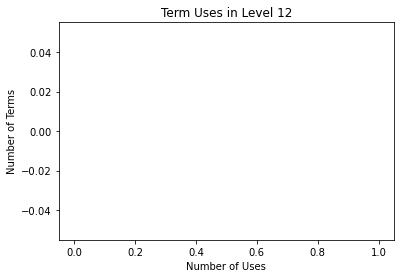

In [24]:
for i in range(1, max_level):
    plt.clf()
    plt.title(f'Term Uses in Level {i+1}')
    plt.xlabel('Number of Uses')
    plt.ylabel('Number of Terms')
    plt.hist(level_usages[i], bins=40)
    plt.savefig(f'figures/mf/level-{i+1}-uses.png')

In [24]:
# curates the term indices that go above the threshold
threshold = 10
common_terms = []
for i in index_tree:
    term = index_tree[i]
    if len(term['gene_inds']) >= threshold:
        term['common'] = True
        common_terms += [i]
    else:
        term['common'] = False

In [25]:
# curates the term indices that go above the threshold
lower_threshold = 10
upper_threshold = 500
useful_terms = []
for i in index_tree:
    term = index_tree[i]
    n = len(term['gene_inds'])
    if n >= lower_threshold and n <= upper_threshold:
        term['useful'] = True
        useful_terms += [i]
    else:
        term['useful'] = False

In [26]:
samples = 1000
jacs = np.zeros(samples)
for i in range(samples):
    t1 = common_terms[np.random.randint(0,len(common_terms))]
    t2 = common_terms[np.random.randint(0,len(common_terms))]
    g1s = set(index_tree[t1]['gene_inds'])
    g2s = set(index_tree[t2]['gene_inds'])
    union = g1s.union(g2s)
    inter = g1s.intersection(g2s)
    jacs[i] = len(inter) / len(union)

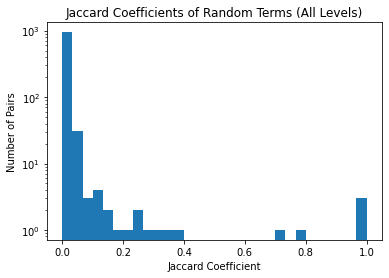

In [27]:
plt.hist(jacs, bins=30, log=True)
plt.title('Jaccard Coefficients of Random Terms (All Levels)')
plt.xlabel('Jaccard Coefficient')
plt.ylabel('Number of Pairs')
plt.savefig('figures/mf/jaccard-all.png')

In [27]:
samples = 500
threshold = 10
jac_levels = np.zeros((8, 500))
for i in range(1,9):
    common_i = []
    for j in index_tree:
        term = index_tree[j]
        if term['level'] == i + 1 and len(term['gene_inds']) >= 10:
            common_i += [j]
    for j in range(samples):
        t1 = common_i[np.random.randint(0,len(common_i))]
        t2 = common_i[np.random.randint(0,len(common_i))]
        if t2 == t1:
            t2 = common_i[np.random.randint(0,len(common_i))]
        g1s = set(index_tree[t1]['gene_inds'])
        g2s = set(index_tree[t2]['gene_inds'])
        union = g1s.union(g2s)
        inter = g1s.intersection(g2s)
        jac_levels[i-1,j] = len(inter) / len(union)

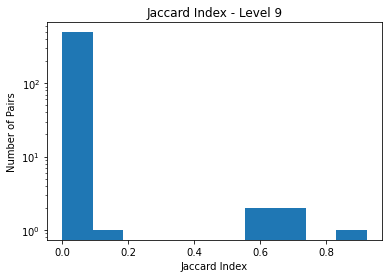

In [29]:
for i in range(1,9):
    js = jac_levels[i-1]
    plt.clf()
    plt.title(f'Jaccard Index - Level {i+1}')
    plt.xlabel('Jaccard Index')
    plt.ylabel('Number of Pairs')
    plt.hist(js, log=True)
    plt.savefig(f'figures/mf/jac-level-{i+1}.png')

In [27]:
for i in index_tree:
    index_tree[i]['gene_set'] = set(index_tree[i]['gene_inds'])

In [34]:
n = len(useful_terms)
jac_adj = np.zeros((n,n))
op = int(n ** 2 / 100)
c = 0
for i in range(n):
    for j in range(n):
        c += 1
        if c % (10 * op) == 0:
            print(f'{int(c / op)}%')
        
        t1 = useful_terms[i]
        t2 = useful_terms[j]
        gs1 = index_tree[t1]['gene_set']
        gs2 = index_tree[t2]['gene_set']
        w = len(gs1.intersection(gs2)) / len(gs1.union(gs2)) 
        jac_adj[i,j] = w

10%
20%
30%
40%
50%
60%
70%
80%
90%
100%


In [49]:
from sklearn.cluster import SpectralClustering
from sklearn.cluster import SpectralCoclustering
from sklearn.cluster import SpectralBiclustering

In [43]:
len(useful_terms)

778

In [50]:
len(go_genes)

13270

In [52]:
go_genes[0]

'44M2.3'

In [54]:
index_tree[1]

{'parents': [1626],
 'children': [],
 'visited': True,
 'level': 10,
 'ancestors': {1,
  439,
  1518,
  1626,
  1841,
  2513,
  4114,
  4139,
  4140,
  4141,
  6732,
  9326},
 'gene_inds': [8333, 8334],
 'common': False,
 'useful': False,
 'gene_set': {8333, 8334}}

In [58]:
len(go_genes)

13270

In [59]:
len(useful_terms)

778

In [60]:
import scipy.sparse as sp

In [102]:
rows = []
cols = [] 
for i in range(len(common_terms)):
    term = common_terms[i]
    row_idx = i
    genes = list(index_tree[term]['gene_set'])
    rows += [row_idx] * len(genes)
    cols += genes

In [103]:
entries = [1] * len(cols)

In [111]:
np.sum(np.sum(anno, axis=0) == 0)

2666

In [91]:
np.min(anno)

0

In [115]:
uses = [0] * (len(go_genes)+1)
for c in cols:
    uses[c] += 1

In [116]:
pointer = 0
cur = 0
shift = [0] * len(uses)
while pointer < len(uses):
    if uses[pointer] == 0:
        shift[pointer] = -1
    else:
        shift[pointer] = cur
        cur += 1
    pointer += 1

In [119]:
for i in range(len(cols)):
    cols[i] = shift[cols[i]]

In [122]:
anno = sp.csr_matrix((entries, (rows, cols)), dtype=int)

In [124]:
scc = SpectralCoclustering(n_clusters=8, svd_method='arpack')

In [125]:
scc.fit(anno)

SpectralCoclustering(n_clusters=8, svd_method='arpack')

In [129]:
scc.row_labels_

array([3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 1, 3, 1, 7, 2, 5, 4, 2, 4, 4, 4, 4,
       4, 3, 3, 3, 3, 7, 1, 6, 1, 1, 7, 7, 1, 7, 3, 7, 1, 1, 7, 7, 1, 7,
       7, 7, 7, 7, 1, 4, 4, 1, 1, 7, 1, 4, 4, 2, 3, 1, 1, 7, 3, 3, 4, 3,
       4, 1, 1, 1, 1, 7, 4, 4, 4, 4, 4, 1, 1, 1, 1, 3, 2, 4, 7, 7, 7, 1,
       1, 7, 7, 7, 7, 7, 7, 3, 6, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 3, 3, 3, 1, 7, 7,
       1, 1, 7, 3, 7, 7, 4, 4, 7, 7, 7, 7, 7, 1, 1, 7, 7, 3, 7, 7, 7, 7,
       7, 1, 1, 3, 1, 7, 7, 7, 7, 7, 7, 3, 7, 1, 1, 1, 1, 1, 1, 1, 3, 1,
       7, 7, 7, 7, 7, 7, 1, 4, 4, 1, 0, 7, 7, 1, 7, 3, 4, 3, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 1, 7, 7, 7, 7, 1, 3, 3, 1, 3, 3, 1,
       2, 7, 7, 1, 1, 7, 1, 7, 1, 1, 4, 7, 1, 7, 7, 7, 7, 6, 6, 7, 7, 3,
       7, 4, 3, 3, 1, 1, 3, 7, 7, 7, 7, 3, 1, 1, 1, 1, 7, 7, 7, 3, 6, 6,
       3, 3, 3, 3, 4, 4, 1, 3, 3, 3, 3, 3, 1, 1, 1, 3, 6, 3, 1, 1, 6, 3,
       3, 4, 1, 3, 3, 3, 3, 3, 1, 1, 1, 4, 1, 3, 6,

In [130]:
ls = scc.row_labels_

In [131]:
for i in range(8):
    print(sum(ls == i))

8
250
54
188
97
18
30
175
